In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 5
Title         = 'Boston'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Boston', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.49167491565268007


MLPRegressor(random_state=RandomState(MT19937) at 0x1867A1B9840)

In [7]:
Reg_Data.Random_Forest()

0.9087753978556509


RandomForestRegressor(random_state=RandomState(MT19937) at 0x1867A1B9840)

In [8]:
Reg_Data.GP()

-5.970450343956584


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.716340804139119


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['crime_rate', 'zoned_lots', 'industry', 'by_river', 'NOX', 'avg_rooms', 'pre_1940', 'emp_distance', 'rad_access', 'tax_rate', 'pupil_tea_rat', 'low_status']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [1.42705684e+00 1.22853186e+01 1.01169806e+01 8.03324100e-02
 5.38099169e-01 6.33845152e+00 6.56772853e+01 4.08933158e+00
 7.81163435e+00 3.75656510e+02 1.83254848e+01 1.15877839e+01]
Std 0:  [2.54861821e+00 2.36170458e+01 6.62167230e+00 2.71807126e-01
 1.12339990e-01 6.56934405e-01 2.81034946e+01 2.10602686e+00
 7.52414233e+00 1.50162824e+02 2.13084818e+00 6.29950054e+00]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight,
                      normalize   = False)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD
[12.777] [1.27770000e+01 1.00000004e-05] [12.77700001]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  1
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[46.227] [4.62269999e+01 1.00000004e-05] [46.22699992]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Optimize FAIL 9 : 2 True
INSTANCE:  2
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[19.775] [1.97750000e+01 1.00000004e-05] [19.775]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  3
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[28.059] [2.80590000e+01 1.00000004e-05] [28.05899999]
Acq_Data_nD
INSTANCE:  4
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[29.361] [2.93610000e+01 1.00000004e-05] [29.36100002]
Acq_Data_nD


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[30.36457083]
[3.03645708e+01 1.00000004e-05]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


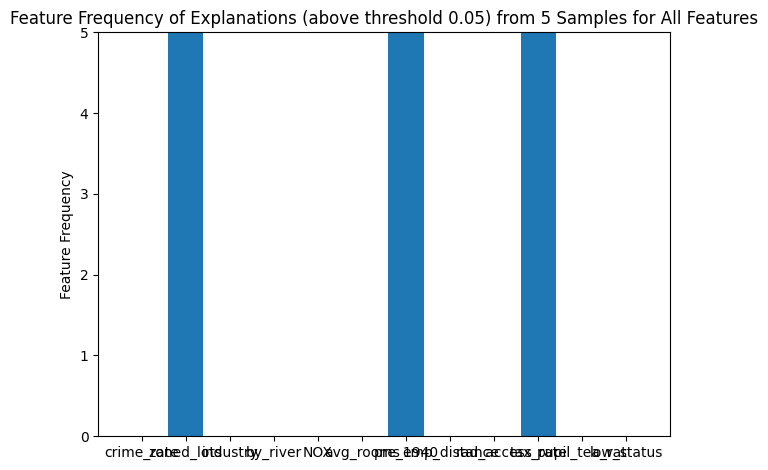

In [18]:
Reg_Stats.Frequency_Plot()


FE:  [8.15708390e-09 8.37520702e-08 3.00545366e-10 1.22739081e-08
 1.62721427e-08] [12.777 46.227 19.775 28.059 29.361] [12.77700001 46.22699992 19.775      28.05899999 29.36100002]
Average, SD, and Max Differences:
y - BB(x):           3.228999999999987  :  1.438463068695194  :  4.560999999999986
y - exp(x):          3.2290000192415738  :  1.4384630765663893  :  4.5610000162721285
BB(x) - exp(x):      2.4151150057605265e-08  :  3.026575228523843e-08  :  8.375207016797503e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  0.06120190031262944


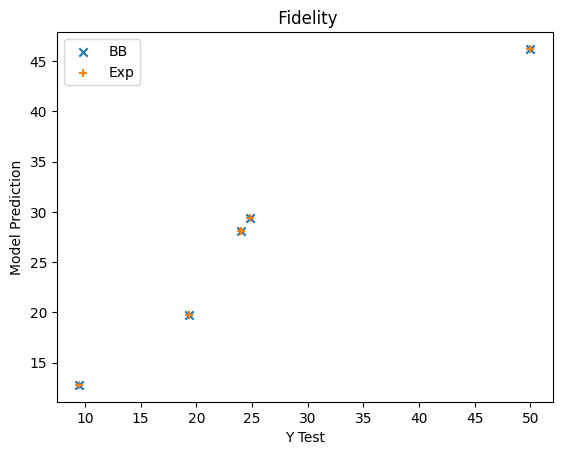

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


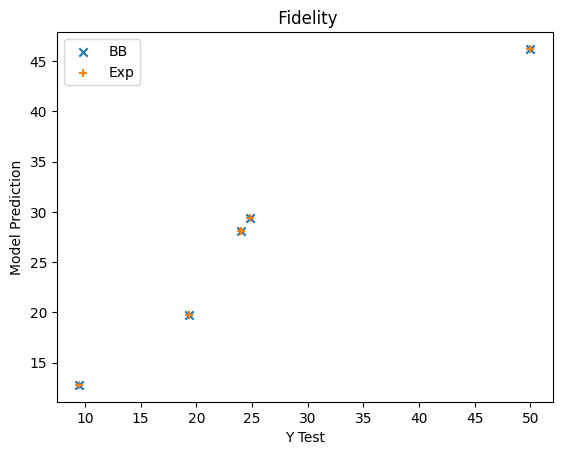

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 12)


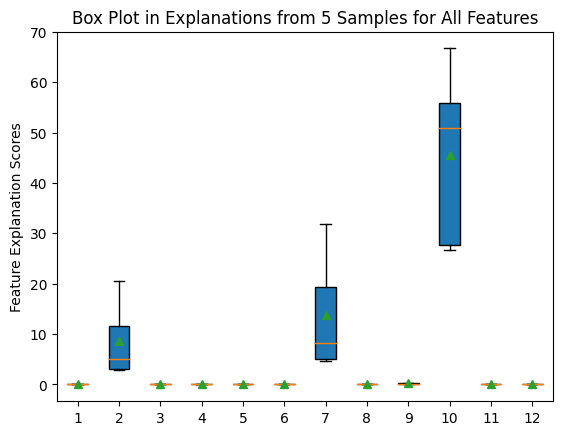

1 -      crime_rate
2 -      zoned_lots
3 -      industry
4 -      by_river
5 -      NOX
6 -      avg_rooms
7 -      pre_1940
8 -      emp_distance
9 -      rad_access
10 -     tax_rate
11 -     pupil_tea_rat
12 -     low_status


In [22]:
Reg_Stats.Box_Plot()


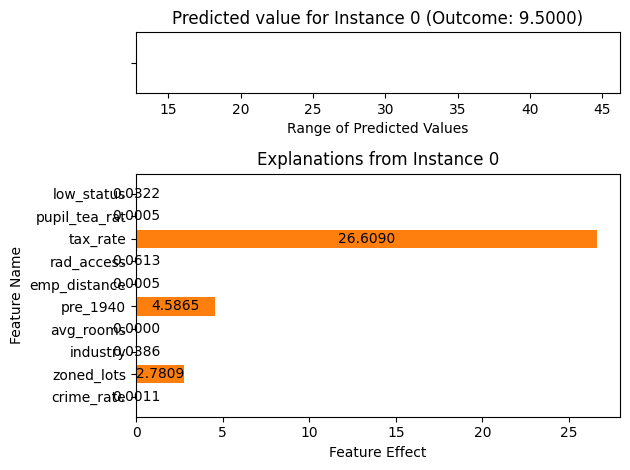

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[7.00308409e-04 2.14904649e+00 2.60586889e-02 1.05421541e-07
 3.15694454e-09 3.47483196e-06 3.69346053e+00 3.34750841e-04
 4.16828322e-02 2.35448273e+01 3.50316423e-04 2.16677924e-02]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[1.82246172 1.82148462 1.82239616 1.82247298 1.82247308 1.82247235
 1.82106705 1.82246533 1.82237374 1.73167301 1.82246514 1.82240347]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[0.26886737 0.27487723 0.26926688 0.2687988  0.26879814 0.26880262
 0.27748202 0.26884537 0.26940368 2.65628862 0.26884649 0.2692223 ]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.27733966e-11 1.20416187e+00 4.29790664e-06 0.00000000e+00
 5.51108583e-09 5.00894684e-04 3.76265147e-01 7.92537499e-04
 1.34276797e-04 1.04104442e+01 7.40268481e-03 2.94117430e-04]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[6.11461848e-03 1.30248820e+00 2.09121716e-01 1.38742369e+00
 2.26675893e-01 1.72827864e-03 2.88502612e+00 1.10084687e-02
 1.62787486e+00 2.60864262e-01 3.19558721e+00 8.86086696e-01]


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[ 8.80842926e+07  1.55219261e+08 -2.70082551e+08 -1.95332660e+08
  3.17472501e+08 -1.41627863e+08  1.32727064e+08 -2.08465341e+07
 -1.19321885e+08 -3.29565250e+07 -3.38127738e+07  3.82651462e+07]


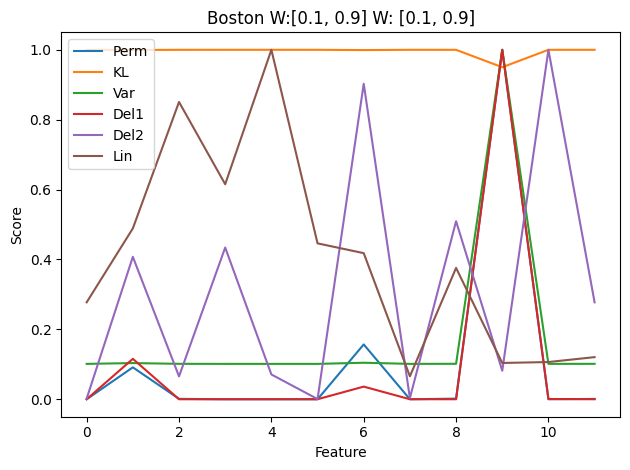

In [30]:
URM_Exp.plot_scores(Title)

In [31]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.41445742e-01  5.40341617e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.87744039e-01  6.44518179e-01  4.89032986e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [32]:
acq_data.Create_BB_plot()

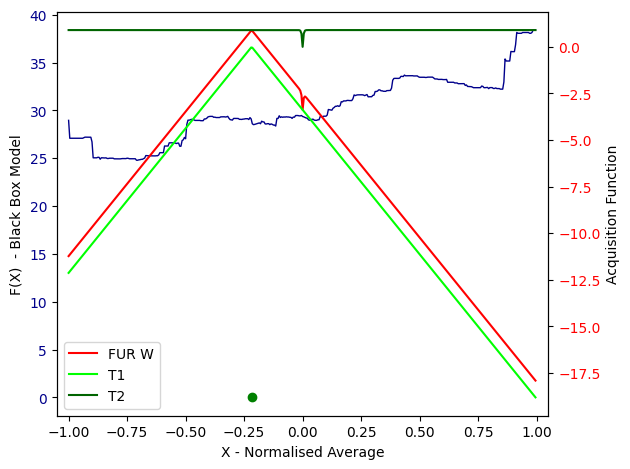

In [33]:
acq_data.plot_point(0)

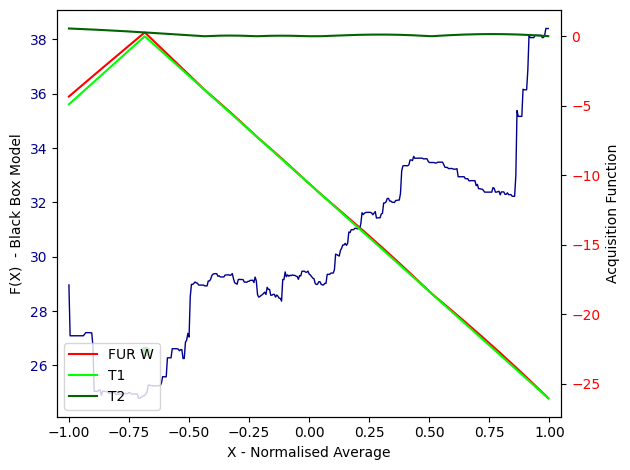

In [34]:
acq_data.plot_point(5)

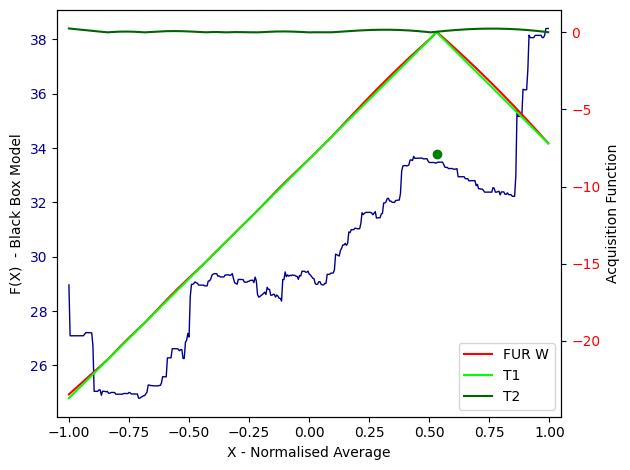

In [35]:
acq_data.plot_point(10)

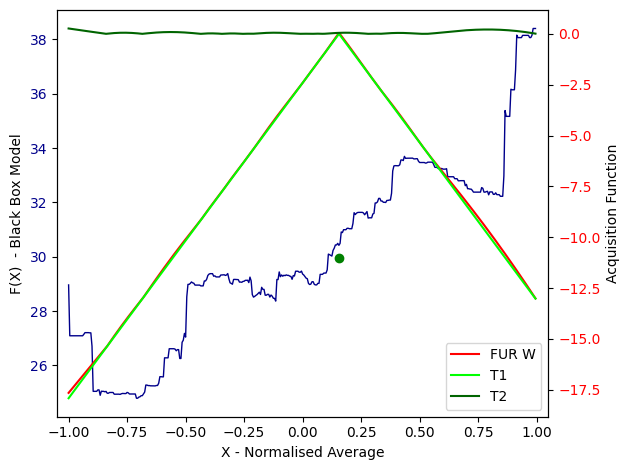

In [36]:
acq_data.plot_point(15)

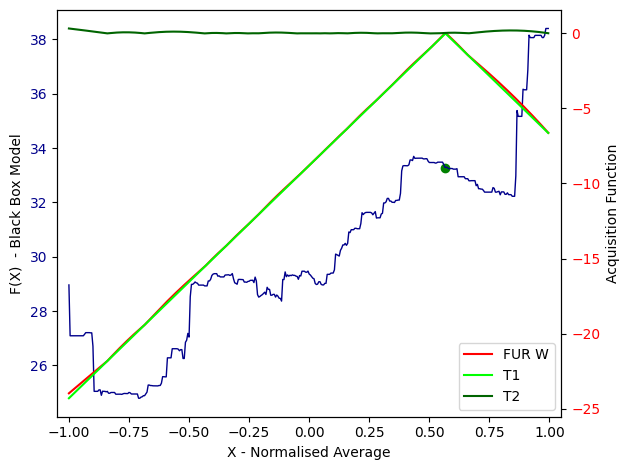

In [37]:
acq_data.plot_point(19)

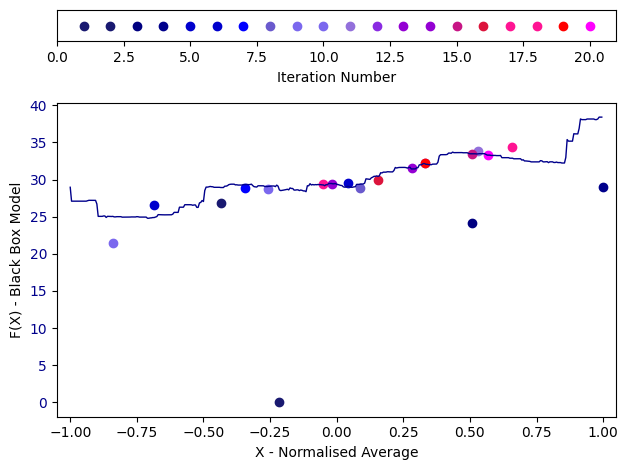

In [38]:
acq_data.plot_all()

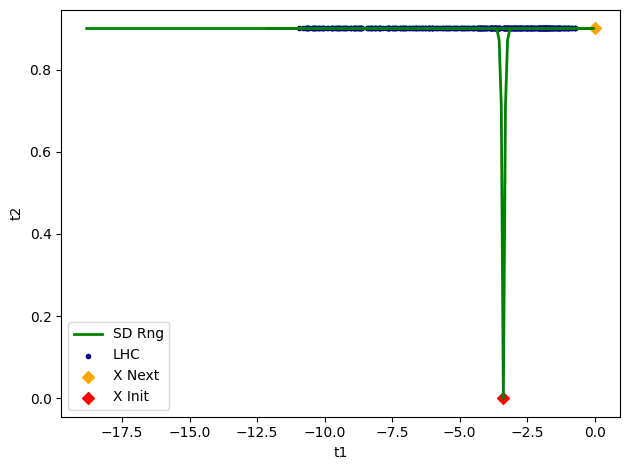

In [39]:
acq_data.plot_t1_t2(0)

In [40]:
#acq_data.plot_t1_t2(1)

In [41]:
#acq_data.plot_t1_t2(2)

In [42]:
#acq_data.plot_t1_t2(3)

In [43]:
#acq_data.plot_t1_t2(4)

In [44]:
#acq_data.plot_t1_t2(5)

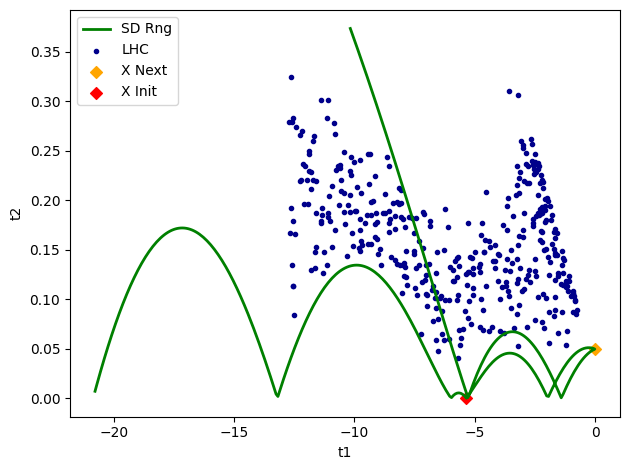

In [45]:
acq_data.plot_t1_t2(6)

In [46]:
#acq_data.plot_t1_t2(7)

In [47]:
#acq_data.plot_t1_t2(8)

In [48]:
#acq_data.plot_t1_t2(9)

In [49]:
#acq_data.plot_t1_t2(10)

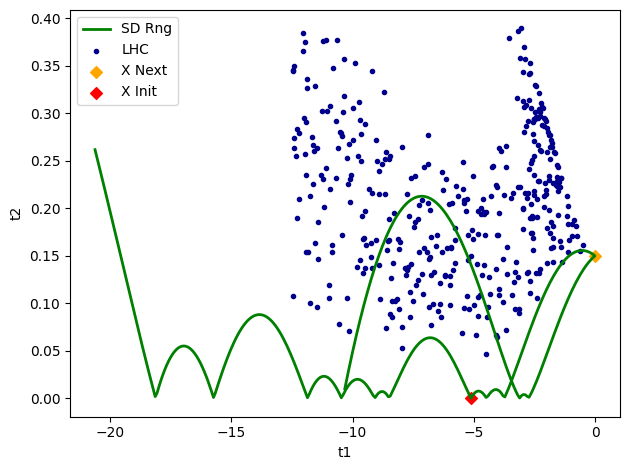

In [50]:
acq_data.plot_t1_t2(11)

In [51]:
#acq_data.plot_t1_t2(12)

In [52]:
#acq_data.plot_t1_t2(13)

In [53]:
#acq_data.plot_t1_t2(14)

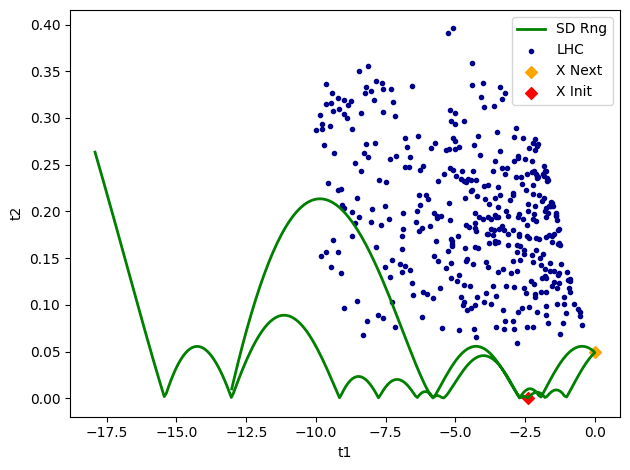

In [54]:
acq_data.plot_t1_t2(15)

In [55]:
#acq_data.plot_t1_t2(16)

In [56]:
#acq_data.plot_t1_t2(17)

In [57]:
#acq_data.plot_t1_t2(18)

In [58]:
#acq_data.plot_t1_t2(19)

FE:  [8.15708390e-09 8.37520702e-08 3.00545366e-10 1.22739081e-08
 1.62721427e-08] [12.777 46.227 19.775 28.059 29.361] [12.77700001 46.22699992 19.775      28.05899999 29.36100002]
Average, SD, and Max Differences:
y - BB(x):           3.228999999999987  :  1.438463068695194  :  4.560999999999986
y - exp(x):          3.2290000192415738  :  1.4384630765663893  :  4.5610000162721285
BB(x) - exp(x):      2.4151150057605265e-08  :  3.026575228523843e-08  :  8.375207016797503e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  0.06120190031262944


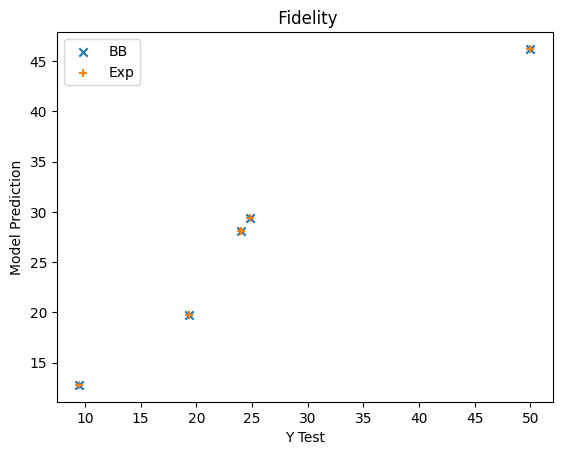

Fidelity:  0.06120190031262944


In [59]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [60]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Jaccard:  1.0


In [61]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

<class 'AttributeError'>: 'BB_Model' object has no attribute 'Feature_Coeffs'

In [ ]:
delete_1_var = Reg_Stats.delete_one()

print('Delete 1 Variance: ', delete_1_var)

In [ ]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [ ]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

In [ ]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [ ]:
print(Reg_Stats.calibration_MAE)

In [ ]:
Reg_Stats.Regression_Calibration_2(plot=True, title=Title)

In [ ]:
Reg_Stats.delete_one()

In [ ]:
Reg_Stats.Results_Summary(Title)